In [100]:
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from extract_data import *
from metrics_plot import *
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from statistics import mean

# RAPPEL MÉTRIQUES
--> elles se décomposent en **micro**, **macro** et **weighted** en général
- micro en général pour la généralisation de la classification binaire à la multi-labels
- macro comme une moyenne de la métrique sur chacun des labels (les labels sont donc supposés équitablement répartis dans l'échantillon) 
- weighted: on fait une moyenne pondérée de la métrique où balance par le poids ie la fréquence d'apparition du label.

\
Ici on choisira **micro**

 On rappelle également que: 
## Precision 
$$precision = \frac{TP}{TP+FP}$$ 
## Recall 
$$recall= \frac{TP}{TP+FN} $$
## F1-score
 $$f1-score= \frac{precision * recall}{precision + recall} $$
## Hamming Loss
 hamming loss = la proportion de labels incorrets 
 
 
 



# Préparation des données

In [2]:
#transform_parquet_to_csv('dataset2.parquet','dataset.csv')

In [3]:
df=pd.read_csv('dataset.csv')
X,Y=extract_values_array(df,p=1,normalize=True,usage=False)
l=list(df.columns[0:22])
l.remove('song_index')

## Mise en forme des résultats 


In [4]:
metrics=['Accuracy','Precision micro', 'Recall micro', 'F1 score micro', 'Hamming-Loss']
final_res=pd.DataFrame(columns=metrics)

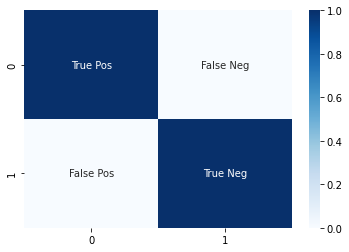

In [5]:
labels = ["True Pos","False Neg","False Pos","True Neg"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(np.eye(2), annot=labels, fmt="", cmap='Blues')
plt.savefig('Modèle Matrice de Confusion')

# Méthode 1: Naive - TOP GENRE 
Attribuer le genre le plus représenté: le rock




In [6]:
df_naif=pd.DataFrame(columns=l)
n=df.shape[0]
for label in l: 
  if label!='rock':
    df_naif[label]=np.zeros(n, dtype=int)
  else :
    df_naif[label]=np.zeros(n, dtype=int)+1
df_naif

,asian,rnb,reggae,blues,pop,dance,folk,arabic-music,indie,rock,...,latin,classical,k-pop,brazilian,metal,rap,jazz,electronic,african,country
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50557,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
50558,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
50559,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
50560,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y_pred = df_naif.values
y_true = df[l].values

In [8]:
r=all_metrics(y_true,y_pred)

In [9]:
final_res.loc['Top Genre']=r

In [10]:
final_res

,Accuracy,Precision micro,Recall micro,F1 score micro,Hamming-Loss
Top Genre,0.107749,0.161782,0.13756,0.148691,0.088215


# Méthode 2: L régressions logistiques unilabel


## Sans sélection de variable (pénalisation Lasso) : AUDIO FEATURES ONLY

### Courbe ROC & AUC par label 

In [11]:
df_hat=pd.DataFrame()
df_test=pd.DataFrame()
n=len(l)
i=0
auc_labels=[]
for label in l:
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y[:,i],test_size=0.3, random_state=5)
    logreg = LogisticRegression(max_iter=10000)
    filename= '../multi-label-classification/joblib_LR_audio_only/'+label
    logreg = load_fit(logreg,X_train,Y_train,filename)
    y_hat = logreg.predict(X_test)
    df_hat[label] = y_hat
    df_test[label]=Y_test
    title='ROC curve ' + label + ' unilabel Logistic Regression'
    name_fig='../multi-label-classification/ROC_LR_audio_only/'+label
    AUC= plot_roc_curve(Y_test, y_hat, title=title, name_fig=name_fig,save=True)
    auc_labels.append(AUC)
    i+=1


<Figure size 432x288 with 0 Axes>

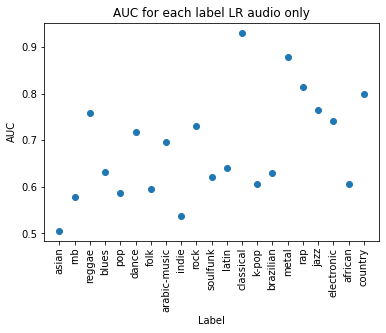

In [12]:
name='../multi-label-classification/ROC_LR_audio_only/auc'
graph_auc(auc_labels,'LR audio only',save=True,name_fig=name)

### Matrices de confusion par label

In [13]:
y_true=df_test.values
y_pred=df_hat.values

In [14]:
conf=multilabel_confusion_matrix(y_true,y_pred)
i=0
for cm in conf:
    label=l[i]
    name_fig= '../multi-label-classification/CM_LR_audio_only/'+label
    plot_confusion_matrix(cm,title=label,classes=[label,'Others'],normalize=True,save=True,name_fig=name_fig)
    i=i+1

<Figure size 432x288 with 0 Axes>

### Résultats: Union des prédictions --> Multilabels

In [15]:
r=all_metrics(y_true,y_pred)
final_res.loc['RL audio (seulement) & sans pénalisation']=r
final_res

,Accuracy,Precision micro,Recall micro,F1 score micro,Hamming-Loss
Top Genre,0.107749,0.161782,0.137560,0.148691,0.088215
RL audio (seulement) & sans pénalisation,0.360142,0.725285,0.431729,0.541267,0.040951


## AVEC sélection de variable : Lasso

Ici il s'agira d'appliquer un critère de pénalisation à la méthode Régression Logistique dans le but de sélectionner des variables, nous choisissons de faire le tuning de l'hyperparamètre pour chaque RL (chaque label). 
Nous comparons 2 résultats: 
- audio features uniquement 
- les deux 

L'argorithme utilisé pour faire l'optimisation de l'hyperparamètre C de la fonction LogisticRegression est  `GridSearchCV(estimator,parameters,cv)`: algorithme récursif qui va comparer en stratifiant l'échantillon train en `cv` parties, l'accuracy `cv`fois. 
La fonction `LogisticRegression` va prendre le paramètre `penalty=l1 `pour faire une sélection Lasso ie sélectionner des variables, l'algorithme de résolution est `saga` c'est une descente de gradient, plus rapide pour leslarges sets de données comme cecui ci, néanmoins très couteux en mémoire et en temps tout de même, nous choisissons le solver `liblinear`moins précis


### AUDIO FEATURES ONLY

##### ROC

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
df_hat=pd.DataFrame()
df_test=pd.DataFrame()
i=0
nb_feature_selected=[]
auc_labels=[]
for label in l:
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y[:,i],test_size=0.3, random_state=5)
    logreg = LogisticRegression(penalty='l1',solver='liblinear',max_iter=5000)
    parameters={'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1]}
    gs=GridSearchCV(logreg,parameters,cv=3,verbose=3)
    filename='../multi-label-classification/joblib_LR_audio_only_penal/'+label
    logreg = load_fit(gs,X_train,Y_train,filename) 
    temp=logreg.best_estimator_.coef_
    n_label=(temp>0).sum()
    nb_feature_selected.append(n_label)
    y_hat= logreg.predict(X_test)
    df_hat[label] = y_hat
    df_test[label]=Y_test
    name_fig= '../multi-label-classification/ROC_LR_audio_only_penal/'+label
    AUC= plot_roc_curve(Y_test, y_hat, title=label, name_fig=name_fig,save=True)
    auc_labels.append(AUC)
    i+=1


<Figure size 432x288 with 0 Axes>

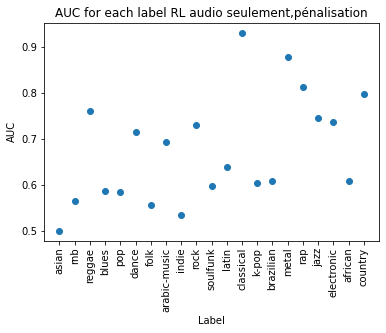

In [18]:
name='../multi-label-classification/ROC_LR_audio_only_penal/AUC'
graph_auc(auc_labels,'RL audio seulement,pénalisation',save=True,name_fig=name)

##### Matrices de confusion

In [19]:
y_true=df_test.values
y_pred=df_hat.values
conf=multilabel_confusion_matrix(y_true,y_pred)
i=0
for cm in conf:
    label=l[i]
    name_fig= '../multi-label-classification/CM_LR_audio_only_penal/'+label
    plot_confusion_matrix(cm,title=label,classes=[label,'Others'],normalize=True,save=True,name_fig=name_fig)
    i=i+1

<Figure size 432x288 with 0 Axes>

##### Résultats

In [20]:
r=all_metrics(y_true,y_pred)
final_res.loc['RL audio (seulement)& pénalisation (optimisée)']=r

### AUDIO & USAGE

In [21]:
X,Y=extract_values_array(df,p=1,normalize=True,usage=True)

##### ROC

In [45]:
def count_audio_usage(z):
    audio=0
    usage=0
    n=len(z) # n'a de sens que si n=384=256+128
    for i in range (len(z)):
        if z[i]>0 and i<256:
            audio+=1
        if z[i]>0 and i>255: 
            usage+=1
    return(audio,usage)

In [111]:
df_hat=pd.DataFrame()
df_test=pd.DataFrame()
i=0
n_features=[]
n_audio=[]
n_usage=[]
auc_labels=[]
for label in l:
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y[:,i],test_size=0.3, random_state=5)
    logreg = LogisticRegression(penalty='l1',solver='liblinear',max_iter=5000)
    parameters={'C':[1e-5,1e-4,1e-3,1e-2,1e-1,1]}
    gs=GridSearchCV(logreg,parameters,cv=3,verbose=3)
    filename='../multi-label-classification/joblib_LR_audio_usage_penal/'+label
    logreg = load_fit(gs,X_train,Y_train,filename) 
    temp=logreg.best_estimator_.coef_[0]
    n_label=(temp>0).sum()
    n_label_a,n_label_u=count_audio_usage(temp)
    n_audio.append(n_label_a)
    n_usage.append(n_label_u)
    n_features.append(n_label)
    y_hat= logreg.predict(X_test)
    df_hat[label] = y_hat
    df_test[label]=Y_test
    name_fig= '../multi-label-classification/ROC_LR_audio_usage_penal/'+label
    AUC= plot_roc_curve(Y_test, y_hat, title=label, name_fig=name_fig,save=True)
    auc_labels.append(AUC)
    i+=1


<Figure size 432x288 with 0 Axes>

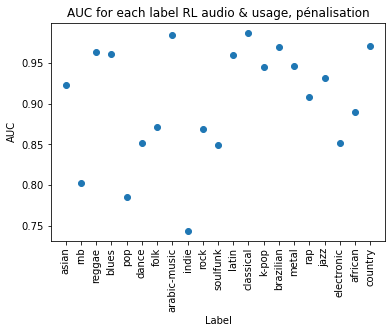

In [112]:
name='../multi-label-classification/ROC_LR_audio_usage_penal/AUC'
graph_auc(auc_labels,'RL audio & usage, pénalisation',save=True,name_fig=name)

##### Étude des variables séléctionnées:

In [113]:
i=0
for i in range (21): 
    n_audio[i]=(n_audio[i]/n_features[i])*100
    n_usage[i]=(n_usage[i]/n_features[i])*100

In [114]:
selected_audio_usage=pd.DataFrame(columns=['Nombre de variables sélectionnées sur 384', "Pourcentage de variables audio" , "Pourcentage de variables usage"])

In [115]:
for i in range (21):
    label=l[i]
    selected_audio_usage.loc[label]=[n_features[i],n_audio[i],n_usage[i]]

In [116]:
m=mean(n_features)
ma=mean(n_audio)
mu=mean(n_usage)
selected_audio_usage.loc['Moyenne sur tous les Labels']=[m,ma,mu]

In [119]:
selected_audio_usage.to_csv('Résultats_sélection_de_variables_RL_audio+usage.csv')

##### Matrice de confusion

In [ ]:
y_true=df_test.values
y_pred=df_hat.values
conf=multilabel_confusion_matrix(y_true,y_pred)
i=0
for cm in conf:
    label=l[i]
    name_fig= '../multi-label-classification/CM_LR_audio_usage_penal/'+label
    plot_confusion_matrix(cm,title=label,classes=[label,'Others'],normalize=True,save=True,name_fig=name_fig)
    i=i+1

##### Résultats

In [ ]:
r=all_metrics(y_true,y_pred)
final_res.loc['RL audio-usage & pénalisation (optimisée)']=r

In [ ]:
final_res


In [ ]:
final_res.to_csv('Résultats_RL.csv')

# QUESTIONS + RESTE A FR

- doit on mettre 'balanced' pour ne pas prendre en compte la faible occurence du label le moins représenté par ex et inversemment  ne pas prédire à tord trop de rock car label le plus représenté??? 

